# What's cooking? Text classification by neural networks.

The task is to guess the cuisine based on cooking receipts.

Data files are provided on Kaggle https://www.kaggle.com/c/whats-cooking

The solution is based on the library *scikit-learn* with the *TensorFlow* backend.
The code shows how to train a **neural network** by *stochastic gradient descent* on the bag-of-words model, how to record and visualize training statistcs and computation grahps and how to handle imbalanced data by assigning class weights to the scoring metric.

Note: the code also shows how to batch sparse matrices in TensorFlow

In [1]:
import tensorflow as tf
import pandas as pnd
import numpy as np
import scipy
import re
import nltk
import math
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import utils
from matplotlib import pyplot as plt

## Data extraction and exploration

In [2]:
# path to data files
train_data_path = 'train.json'

data = pnd.read_json(train_data_path)

# have a look
data[:10]

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


In [3]:
y = data['cuisine']
X = data.drop(['id','cuisine'],axis=1)

Preprocess the data, so that every row contains a comma-separated list of ingredients.

In [4]:
def preprocess(X):
    X['ingredients'] = X['ingredients'].apply(lambda t: ','.join(t))
    X['ingredients'] = X['ingredients'].astype(str)
    return X

X = preprocess(X)
X[0:10]

,ingredients
0,"romaine lettuce,black olives,grape tomatoes,ga..."
1,"plain flour,ground pepper,salt,tomatoes,ground..."
2,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,"water,vegetable oil,wheat,salt"
4,"black pepper,shallots,cornflour,cayenne pepper..."
5,"plain flour,sugar,butter,eggs,fresh ginger roo..."
6,"olive oil,salt,medium shrimp,pepper,garlic,cho..."
7,"sugar,pistachio nuts,white almond bark,flour,v..."
8,"olive oil,purple onion,fresh pineapple,pork,po..."
9,"chopped tomatoes,fresh basil,garlic,extra-virg..."


In [5]:
X.shape

(39774, 1)

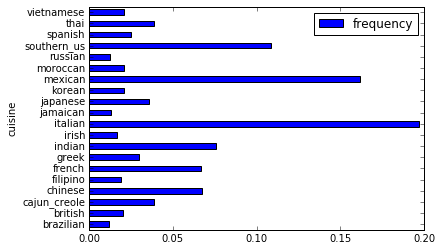

In [6]:
tmp = pnd.DataFrame(data =  pnd.crosstab(y,1)/len(y))
tmp.columns = ['frequency']
tmp.plot(kind='barh')
plt.show()

We have ~ 40k rows of data, and 20 classes which are *highly imbalanced*. This is one issue we will fight later.

## Building the bag-of-words model

In [274]:
# build a tokenizer with the use of stemming

pattern = r'[^,]+'
pattern = re.compile(pattern)
stemmer = nltk.stem.PorterStemmer()
def tokenize(text):
    tokens = pattern.findall(text)
    return [stemmer.stem(i) for i in tokens]

print( tokenize(str( X.loc[0].ingredients )) )

['romaine lettuc', 'black ol', 'grape tomato', 'garlic', 'pepper', 'purple onion', 'season', 'garbanzo bean', 'feta cheese crumbl']


In [569]:
# build the dictionary

counts = TfidfVectorizer(min_df=10,max_df=0.5,tokenizer=tokenize, norm=None, use_idf=False).fit(X['ingredients'])
#counts = CountVectorizer(min_df=3,tokenizer=tokenize).fit(X['ingredients'])
voc_size = len(counts.vocabulary_)
print('Vocabulary is of size {0}'.format(voc_size))

Vocabulary is of size 2409


In [570]:
# do a train-test split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=11,stratify=y)

In [571]:
# build the document-term matrix

X_train_f = counts.transform(X_train['ingredients'])
X_test_f = counts.transform(X_test['ingredients'])

In [572]:
# encode targets

class_name = y_train.unique()

y_train = y_train.apply(lambda t: (class_name==t).argmax())
y_test = y_test.apply(lambda t: (class_name==t).argmax())

## Building a model in TensforFlow

In [706]:
n_classes = len(class_name)
n_features = voc_size

In [707]:
# lunch the session, reset the graph
tf.reset_default_graph()
sess = tf.InteractiveSession()

# build the model
tf.set_random_seed(13)

# network parameters
C_HIDDEN1 = 600
C_HIDDEN2 = 100 
C_2Layer = False 

with tf.name_scope('inputs'):
    # note: we will be using batches with the size specificied later - leave this dimension unknown for now
    tf_X = tf.sparse_placeholder(shape=[None,n_features],dtype=tf.float32,name='X')
    tf_y = tf.placeholder(shape=[None],dtype=tf.int32,name='y') # labels

with tf.name_scope('model_weights'):
    if C_2Layer == False:
        C_HIDDEN2 = C_HIDDEN1
    # note: intitializing big weights - e.g. ones - gives bad convergence !!!
    W1 = tf.Variable(tf.random_normal(shape=[n_features, C_HIDDEN1],stddev=0.05), name='W1')
    b1 = tf.Variable(tf.zeros(shape=[C_HIDDEN1]),dtype=tf.float32, name='b1')

    W2 = tf.Variable(tf.random_normal(shape=[C_HIDDEN1, C_HIDDEN2], stddev = 0.05), name='W2')
    b2 = tf.Variable(tf.zeros(shape=[C_HIDDEN2]),dtype=tf.float32, name='b2')
    
    W3 = tf.Variable(tf.random_normal(shape=[C_HIDDEN2, n_classes], stddev=0.05), name='W3')
    b3 = tf.Variable(tf.zeros(shape=[n_classes]),dtype=tf.float32, name='b3')

with tf.name_scope('hidden-layer'):
    # transform the feature input 
    hidden_out = tf.add( tf.sparse_tensor_dense_matmul(tf_X, W1), b1)
    # apply the (first) rectifier
    hidden_out = tf.nn.relu(hidden_out)
    if C_2Layer:
        # project to the next layer
        hidden_out = tf.add( tf.matmul(hidden_out, W2), b2)   
        # apply the rectifier
        hidden_out = tf.nn.relu(hidden_out)
    # transform to the output shape 
    logits = tf.add(tf.matmul(hidden_out, W3),b3)

with tf.name_scope('class_weights'):
    # define class weights - uniform for now!
    w_class = tf.Variable(np.ones(n_classes).reshape(-1,1),dtype=np.float32,name='class_weights',trainable=False) 
    
with tf.name_scope('loss'):
    labels = tf.one_hot(tf_y,n_classes)
    weights = tf.reduce_sum( tf.matmul(labels, w_class), 1 ) # dim = [batch_size]
    entropy = tf.losses.softmax_cross_entropy(logits=logits,onehot_labels=labels, weights=weights)
    regularizer = tf.contrib.layers.l2_regularizer(scale=1e-5)
    weights = [W1,W3]
    reg_penalty = tf.contrib.layers.apply_regularization(regularizer, weights)
    loss = entropy  + reg_penalty

with tf.name_scope('optimization'):
    # set the auxiliary global step count
    global_step = tf.Variable(0,trainable=False)
    learn_rate = tf.Variable(0.05,trainable=False)
    # define the optimization algorithm with a fixed learning rate
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learn_rate).minimize(loss, global_step=global_step)

In [708]:
# read data in batches in a cyclic way 

# we will be unziping a large sparse matrix in batches, to keep the memory usage low

# note the data has been already shuffled when doing train/test split)

class DataCyclicBatches():
    
    def __init__(self, batch_size, n_samples, X, y, remainder=False):
        self.step = 0
        self.batch_size = batch_size
        self.n_samples = n_samples
        if remainder:
            self.n_batch = math.ceil( n_samples / batch_size )
        else:
            self.n_batch = int( n_samples / batch_size )
        self.X = X
        self.y = y
        self.remainder = remainder
        return None

    def get_next(self):
        if self.step >= self.n_batch:
            self.step = 0
        start = self.step * self.batch_size
        end = min((self.step+1) * self.batch_size, self.n_samples)
        self.step = self.step+1        
        return self.X[start:end], self.y[start:end]        

In [709]:
# model testing 

def preds(mini_batch_size=1000):
    # note: this keeps the memory usage low, by unziping the sparse feature matrix in batches
    total_score = 0
    preds = []
    test_batches = DataCyclicBatches(batch_size=mini_batch_size, n_samples=X_test_f.shape[0],
                                         X = X_test_f, y = y_test, remainder=True)
    for i in range(test_batches.n_batch): 
        X_b, y_b = test_batches.get_next()
        with tf.name_scope('predictions'):
            # !!! wrap the sparse matrix (TensorFlow don't accept sparse matrix directly)
            tmp = scipy.sparse.coo_matrix(X_b)
            X_b_sparse = tf.SparseTensorValue(indices=np.array([tmp.row, tmp.col]).T,
                                              values=tmp.data,dense_shape=tmp.shape)
            _, logits_batch = sess.run([loss, logits], feed_dict={tf_X:X_b_sparse,tf_y:y_b})
            odds = tf.nn.softmax(logits_batch)
            heaviest = sess.run(tf.argmax( odds, 1))
        preds.append(heaviest)
    return preds

In [710]:
# model training and evaluation

test_accuracy = tf.Variable(0,dtype=tf.float32,trainable=False)

with tf.name_scope('summary'):
    train_summ = tf.summary.scalar('train_loss', loss)
    test_summ = tf.summary.scalar('test_accuracy', test_accuracy)

def train(mini_batch_size=256,rate=1,n_epochs=25, shuffle=False, record=True):
    # set the larning rage
    sess.run(learn_rate.assign(rate))
    # start learning
    train_batches = DataCyclicBatches(batch_size=mini_batch_size, n_samples=X_train_f.shape[0],
                                         X = X_train_f, y = y_train)
    for _ in range(n_epochs):
        # do a full pass over data
        for i in range(train_batches.n_batch): 
            X_b, y_b = train_batches.get_next()
            tmp = scipy.sparse.coo_matrix(X_b)
            X_b_sparse = tf.SparseTensorValue(indices=np.array([tmp.row, tmp.col]).T,
                                              values=tmp.data,dense_shape=tmp.shape)
            summary,_, train_loss = sess.run([train_summ,optimizer,loss],feed_dict={tf_X:X_b_sparse,tf_y:y_b})
        # record training score
        if record:
            summary_writer.add_summary(summary, global_step.eval())
        # compute and record testing score
        if record:
            y_pred = np.concatenate( preds() )
            _ = sess.run(test_accuracy.assign(f1_score()))
            summary = sess.run(test_summ)
            summary_writer.add_summary(summary, global_step.eval())    
    return None

## Evaluation

Since the classes are imbalanced, the more relevant score than accuracy is f1 score agregated on the class level (*macro*). This gives the estimate of how the model performs accorss the classes. 

In [711]:
def f1_score():
    y_pred = np.concatenate( preds() )
    return metrics.f1_score(y_test,y_pred,average='macro')

Finally we can train and evaluate the network.

In [815]:
# intialize
sess.run(tf.global_variables_initializer())

# enable recording
summary_writer = tf.summary.FileWriter('./neural', sess.graph)

# disable warnings for undefined f1-score - will be replaced by 0
import warnings
warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

# train and evaluate
print('Training...')
C_HIDDEN1 = 500
train(rate=0.75,mini_batch_size=256,n_epochs=20, record=False)

print('Evaluating')
y_pred = np.concatenate( preds() )
print('F1-score (micro-averaged)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro-averaged)={0}'.format( f1_score()))

Training...
Evaluating
F1-score (micro-averaged)=0.7679544121344172
F1-score (macro-averaged)=0.6908707446375708


We can download and plot the recored training and testing statistics using the Tensorboard tool (in Tensorboard, they are interactive though)

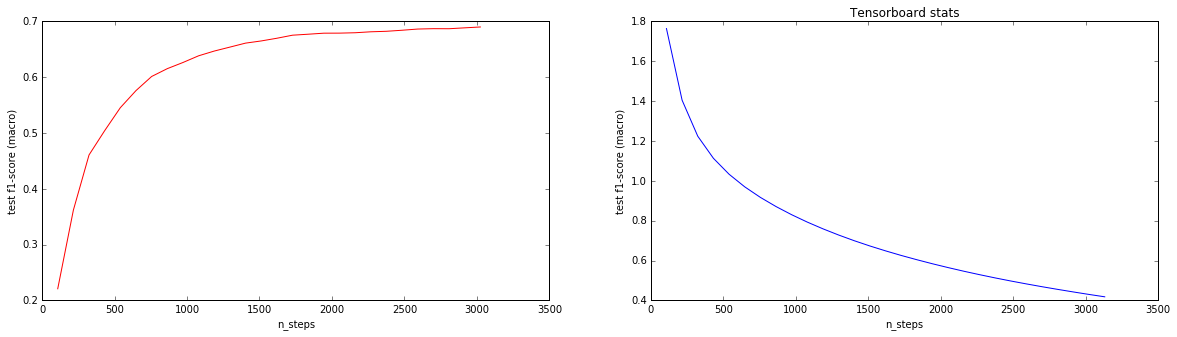

In [618]:
import os

fig = plt.figure(figsize=[20,5])

ax = fig.add_subplot(121)
ax.set_xlabel('n_steps')
ax.set_ylabel('test f1-score (macro)')
tmp = pnd.read_csv('test_accuracy.csv',header=0)
ax.plot(tmp['Step'],tmp['Value'],'red')

ax = fig.add_subplot(122)
ax.set_xlabel('n_steps')
ax.set_ylabel('train loss')
tmp = pnd.read_csv('train_loss.csv',header=0)
ax.plot(tmp['Step'],tmp['Value'])

plt.show()

Accuracy accross the classes is illustrated by the confusion matrix, ploted in blue-red scale below.

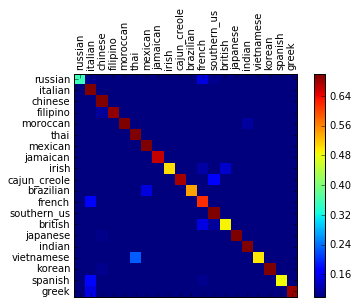

In [819]:
def report_confusion():
    tmp = np.float32( metrics.confusion_matrix(y_test, y_pred)) 
    for i in range(tmp.shape[0]):
        t = tmp[i].sum()
        tmp[i] = tmp[i]/t

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(tmp, vmin=0.1, vmax=0.7)
    fig.colorbar(cax)
    ticks = np.arange(0,n_classes,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(class_name, rotation=90)
    ax.set_yticklabels(class_name)
    plt.show()
    
report_confusion()

We see that *frequent classes are often consufed*, e.g. italian, southern_us, french.

## Handling imbalanced data - class weights

By assigning smaller weights to more common classes we can trade errors, which otherwise concentrate on majority classes.

In [822]:
sess.run(tf.global_variables_initializer())

summary_writer = tf.summary.FileWriter('./neural', sess.graph)

# modify the weights
freq_classes = pnd.crosstab(y,1)
freq_classes = freq_classes.loc[class_name] # consistent order
tmp = np.array(1/freq_classes)**0.6
sess.run(w_class.assign( tmp/tmp.sum()*n_classes))

C_HIDDEN1 = 600

train(rate=0.5, n_epochs=60, mini_batch_size=512,record=False)

y_pred = np.concatenate( preds() )
print('F1-score (micro)={0}'.format( metrics.f1_score(y_test,y_pred,average='micro')))
print('F1-score (macro)={0}'.format( metrics.f1_score(y_test,y_pred,average='macro')))

F1-score (micro)=0.7626749350540518
F1-score (macro)=0.6904117275916817


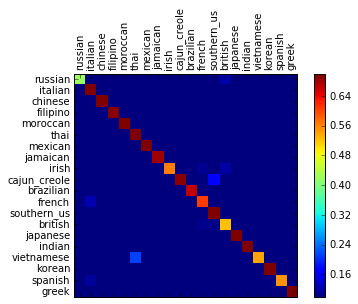

In [821]:
report_confusion()

Now the errors in the confusion matrix are distributed more uniformly. This shows that by modifying class weights we can improve the classifier.

In [ ]:
sess.close()